# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


# 1. Подготовка данных

Импортируем необходимые для работы библиотеки. 

In [1]:
%matplotlib inline
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from pylab import rcParams
rcParams['figure.figsize'] = 11, 7
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import numpy as np
import scipy.stats as st
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

Импортируем датасеты, посмототрим на информацию о них. 

In [2]:
data_train = pd.read_csv('/datasets/gold_recovery_train.csv', parse_dates=True, index_col='date')
data_test = pd.read_csv('/datasets/gold_recovery_test.csv', parse_dates=True, index_col='date')
data_full = pd.read_csv('/datasets/gold_recovery_full.csv', parse_dates=True, index_col='date')

In [3]:
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_c

In [4]:
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                    

In [5]:
print(data_full.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant                      21170 non-null float64
primary_c

data_train - обучающая выборка содержит в себе все признаки объектов. При этом в ней содержатся даже те данные, которые получаются уже в процессе обработки. <br>
data_test - тестовая выборка, не содержит в себе некоторые признаки, которые замеряются и/или рассчитываются позже, а также не содержит целевой признак. <br>
data_full - полный датасет, который включает в себя обучающую и тестовую выборку со всеми признаками. 

### Проверка верности расчета rougher.output.recovery

Прежде, чем приступить к предобработке данных, проверим расчет эффективности обогащения (rougher.output.recovery) на обучающей выборке. Формула для расчета rougher.output.recovery выглядит так: (C * (F - T)) / (F * (C - T)) * 100, где C - rougher.output.concentrate_au, F - rougher.input.feed_au, T - rougher.output.tail_au. Создадим столбец с расчетом по данной формуле, после чего найдем МАЕ между нашими расчетами и значением признака. 

В необходимых для расчета столбцах есть пропущенные значения. Чтобы формула работала корректно, создадим отдельный датафрейм, в котором удалим строки с пропущенными значениям. Работать будем с ним.

In [6]:
data_testing = data_train[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']]
data_testing = data_testing.dropna()
data_testing.head()

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery
date,,,,
2016-01-15 00:00:00,19.793808,6.486150,1.170244,87.107763
2016-01-15 01:00:00,20.050975,6.478583,1.184827,86.843261
2016-01-15 02:00:00,19.737170,6.362222,1.162562,86.842308
2016-01-15 03:00:00,19.320810,6.118189,1.079755,87.226430
2016-01-15 04:00:00,19.216101,5.663707,1.012642,86.688794


In [7]:
C = data_testing['rougher.output.concentrate_au'] 
F = data_testing['rougher.input.feed_au']
T = data_testing['rougher.output.tail_au']

data_testing['recovery_test'] = (C * (F - T)) / (F * (C - T)) * 100
data_testing['recovery_test'].head(5)

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
Name: recovery_test, dtype: float64

In [8]:
mae = mean_absolute_error(data_testing['rougher.output.recovery'], data_testing['recovery_test'])
mae

9.444891926100695e-15

Мы видим, что значение MAE очень низкое, а это значит, что значения признака в исходном датафрейме практически не отличаются от расчитанных нами значений. То есть значения можно считать верными. 
<br> Также мы узнали, что в исходном датафрейме в небходимых для расчета столбwах есть пропущенные значения. Будем учитывать это в дальнейшем.  

### Анализ признаков в выборках

Выше мы видели, что у нас есть 86 столбцов в обучающей выборке и 52 столбца в тестовой выборке. Это связано с тем, что значение некоторых признаков становится известно только в процессе обработки руды. Соответственно, при обучении моделей мы эти признаки учитывать не можем, потому что в работе они нам известны не будут. То есть нам необходимо удалить из обучающей выборки столбцы, которые отсутствуют в тестовой выборке. При этом в тестовой выборке у нас отсутствуют целевые признаки. Необходимо добавить их в тестовую выборку из полной (rougher.output.recovery и final.output.recovery).

Добавим необходимые столбцы в тестовую выборку. 

In [9]:
data_add_to_test = data_full[['rougher.output.recovery', 'final.output.recovery']]
data_test = data_test.join(data_add_to_test)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                    

Оставим в обучающей выборке только те столбцы, которые есть в тестовой. 

In [10]:
data_train = data_train[data_test.columns]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 54 columns):
primary_cleaner.input.sulfate                 15553 non-null float64
primary_cleaner.input.depressant              15598 non-null float64
primary_cleaner.input.feed_size               16860 non-null float64
primary_cleaner.input.xanthate                15875 non-null float64
primary_cleaner.state.floatbank8_a_air        16820 non-null float64
primary_cleaner.state.floatbank8_a_level      16827 non-null float64
primary_cleaner.state.floatbank8_b_air        16820 non-null float64
primary_cleaner.state.floatbank8_b_level      16833 non-null float64
primary_cleaner.state.floatbank8_c_air        16822 non-null float64
primary_cleaner.state.floatbank8_c_level      16833 non-null float64
primary_cleaner.state.floatbank8_d_air        16821 non-null float64
primary_cleaner.state.floatbank8_d_level      16833 non-null float64
rougher.input.feed_ag       

Теперь признаки в наших выборках идентичны, значит, модель будет обучаться только на тех данных, которые будут доступны нам в самом начале обработки. 

### Обработка пропущенных значений

И в обучающей, и в тестовой выборках у нас есть пропущенные значения. Работать с пропущенными значениями в целевых признаках нельзя - модель обучится некорректно. Сначала удалим строки с пропущенными значения в целевых признаках, а потом будем обрабатывать остальные значения. 

In [11]:
data_train.dropna(subset=['final.output.recovery', 'rougher.output.recovery'], inplace=True)
data_test.dropna(subset=['final.output.recovery', 'rougher.output.recovery'], inplace=True)
print(data_train.info())
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 54 columns):
primary_cleaner.input.sulfate                 14129 non-null float64
primary_cleaner.input.depressant              14117 non-null float64
primary_cleaner.input.feed_size               14149 non-null float64
primary_cleaner.input.xanthate                14049 non-null float64
primary_cleaner.state.floatbank8_a_air        14145 non-null float64
primary_cleaner.state.floatbank8_a_level      14148 non-null float64
primary_cleaner.state.floatbank8_b_air        14145 non-null float64
primary_cleaner.state.floatbank8_b_level      14148 non-null float64
primary_cleaner.state.floatbank8_c_air        14147 non-null float64
primary_cleaner.state.floatbank8_c_level      14148 non-null float64
primary_cleaner.state.floatbank8_d_air        14146 non-null float64
primary_cleaner.state.floatbank8_d_level      14148 non-null float64
rougher.input.feed_ag       

Удаление строк с пропущенными значениями в целевых признаках прошло успешно. Перейдем к пропущенным значениям в остальных признаках. Данные в наших выборках упорядочены по времени. Соседние по времени значения признаков очень близки, поэтому мы можем использовать метод ffill для заполнения - он заполнит пропущенные значения на основании соседних по времени. 

In [12]:
data_train = data_train.fillna(method='ffill')
data_test = data_test.fillna(method='ffill')
print(data_train.info())
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 54 columns):
primary_cleaner.input.sulfate                 14149 non-null float64
primary_cleaner.input.depressant              14149 non-null float64
primary_cleaner.input.feed_size               14149 non-null float64
primary_cleaner.input.xanthate                14149 non-null float64
primary_cleaner.state.floatbank8_a_air        14149 non-null float64
primary_cleaner.state.floatbank8_a_level      14149 non-null float64
primary_cleaner.state.floatbank8_b_air        14149 non-null float64
primary_cleaner.state.floatbank8_b_level      14149 non-null float64
primary_cleaner.state.floatbank8_c_air        14149 non-null float64
primary_cleaner.state.floatbank8_c_level      14149 non-null float64
primary_cleaner.state.floatbank8_d_air        14149 non-null float64
primary_cleaner.state.floatbank8_d_level      14149 non-null float64
rougher.input.feed_ag       

Заполнение пропусков прошло успешно. 

# Вывод 

Мы загрузили данные, проверили верность расчетов целевых признаков, удалили лишние столбцы в выборках, добавили нужные. Удалили строки с пропусками в целевых признаках и заполнили пропуски в остальных признаках. Данные готовы к дальнейшему анализу. 

# 2. Анализ данных

В этом блоке мы посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки и опишем выводы.<br><br>
Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.<br><br>
Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Есть ли аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишем выводы.

### Как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

Для анализа изменений концентрации металлов на различных этапах очистки мы будем использовать полный датасет (data_full). Построим графики для каждого металла по значениям столбцов 'rougher.input.feed_...',
'rougher.output.concentrate_...',
'primary_cleaner.output.concentrate_...,
'final.output.concentrate_...'. 
<br><br>
Создадим датасеты для каждого вида металла. 

In [13]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant                      21170 non-null float64
primary_c

In [14]:
data_au = data_full[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
data_au = pd.DataFrame(data_au.sum(axis = 0, skipna = True)).reset_index()

data_ag = data_full[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]
data_ag = pd.DataFrame(data_ag.sum(axis = 0, skipna = True)).reset_index()

data_pb = data_full[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]
data_pb = pd.DataFrame(data_pb.sum(axis = 0, skipna = True)).reset_index()

data_au

,index,0
0,rougher.input.feed_au,171116.552519
1,rougher.output.concentrate_au,404399.395076
2,primary_cleaner.output.concentrate_au,660723.545867
3,final.output.concentrate_au,905226.520007


Выделение отдельных датасетов прошло успешно. Построим гистограммы по каждому металлу. 

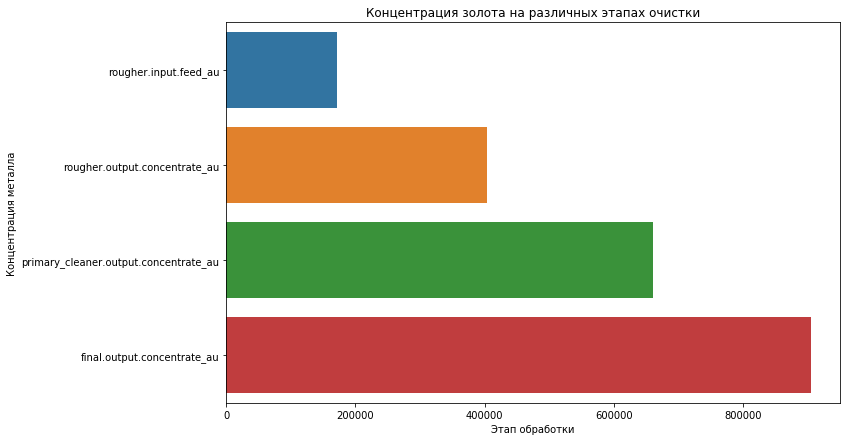

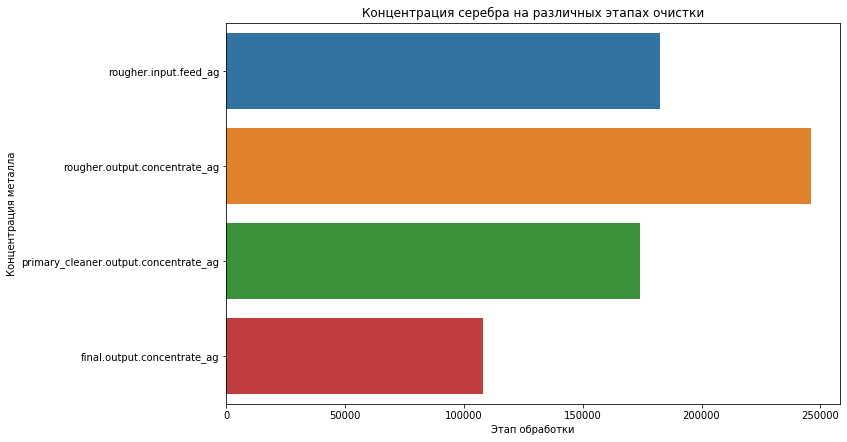

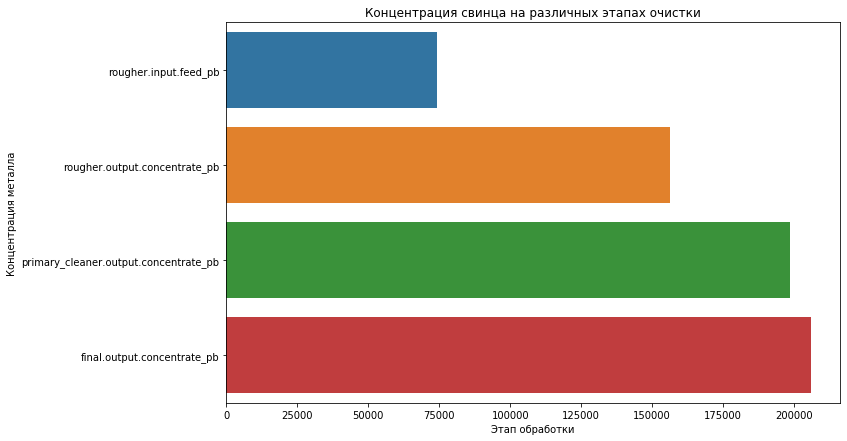

In [15]:
sns.barplot(x=0, y='index', data=data_au)\
    .set(xlabel='Этап обработки', ylabel='Концентрация металла', title='Концентрация золота на различных этапах очистки')
plt.show()

sns.barplot(x=0, y='index', data=data_ag)\
    .set(xlabel='Этап обработки', ylabel='Концентрация металла', title='Концентрация серебра на различных этапах очистки')
plt.show()

sns.barplot(x=0, y='index', data=data_pb)\
    .set(xlabel='Этап обработки', ylabel='Концентрация металла', title='Концентрация свинца на различных этапах очистки')
plt.show()

Из графиков выше мы видим, что концентрация золота и свинца с прохождением каждого этапа растет, а вот концентрация серебра растет после флотации и падает после прохождения следующих этапов. 

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

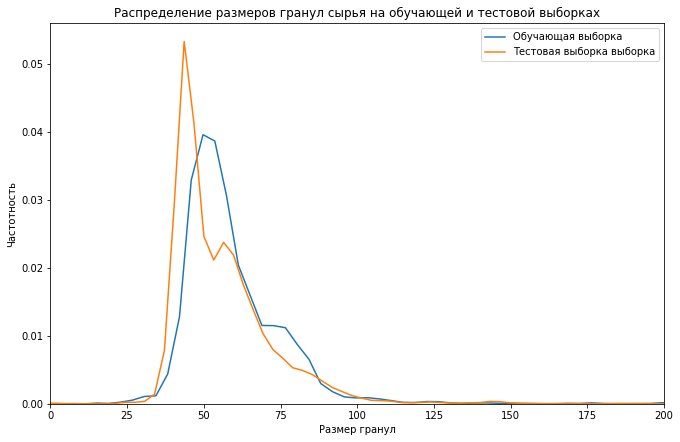

In [16]:
sns.kdeplot(data_train['rougher.input.feed_size'], label='Обучающая выборка')\
    .set(xlabel='Размер гранул', ylabel='Частотность', title='Распределение размеров гранул сырья на обучающей и тестовой выборках')
sns.kdeplot(data_test['rougher.input.feed_size'], label='Тестовая выборка выборка')\
    .set(xlabel='Размер гранул', ylabel='Частотность')
plt.xlim(0, 200)
plt.legend()
plt.show()

Из графика выше мы видим, что распределеения размеров гранул сырья на обучающей и тестовой выборках очень похожи, а значит, значения этого признака не будут негативно влиять на оценку модели. 

### Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Есть ли аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишем выводы.

Просуммируем 4 вещества: au, ag, pb, sol для каждой группы признаков: rougher.input.feed, rougher.output.concentrate, final.output.concentrate. Для этого будем использовать полную выборку. 

In [17]:
data_full['rougher.input.feed_sum'] = data_full['rougher.input.feed_au'] + data_full['rougher.input.feed_ag'] +\
    + data_full['rougher.input.feed_pb'] + data_full['rougher.input.feed_sol']

data_full['rougher.output.concentrate_sum'] = data_full['rougher.output.concentrate_au'] + data_full['rougher.output.concentrate_ag'] +\
    + data_full['rougher.output.concentrate_pb'] + data_full['rougher.output.concentrate_sol']

data_full['final.output.concentrate_sum'] = data_full['final.output.concentrate_au'] + data_full['final.output.concentrate_ag'] +\
    + data_full['final.output.concentrate_pb'] + data_full['final.output.concentrate_sol']

data_full['final.output.concentrate_sum']

date
2016-01-15 00:00:00    63.644396
2016-01-15 01:00:00    63.957723
2016-01-15 02:00:00    64.311180
2016-01-15 03:00:00    63.573449
2016-01-15 04:00:00    64.004667
                         ...    
2018-08-18 06:59:59    68.098589
2018-08-18 07:59:59    68.274362
2018-08-18 08:59:59    68.226068
2018-08-18 09:59:59    68.200449
2018-08-18 10:59:59    68.353154
Name: final.output.concentrate_sum, Length: 22716, dtype: float64

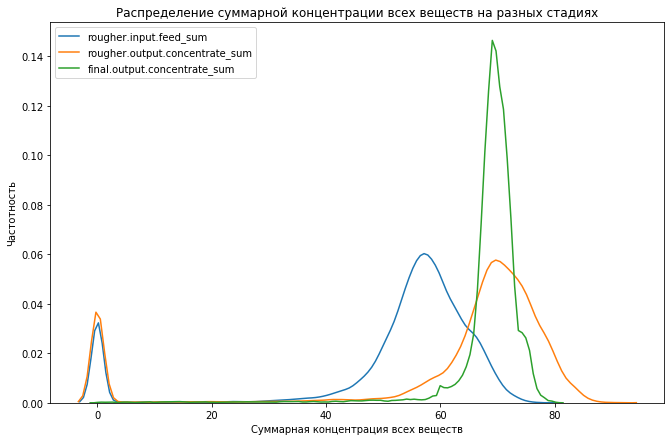

In [18]:
fich_name = ['rougher.input.feed_sum', 'rougher.output.concentrate_sum', 'final.output.concentrate_sum']

for name in fich_name:
    sns.kdeplot(data_full[name], label=name )\
        .set(xlabel='Суммарная концентрация всех веществ', ylabel='Частотность', 
             title='Распределение суммарной концентрации всех веществ на разных стадиях')

На графике выше мы видим пики около нуля в сырье и черновом концентрате. Нулевые значения, скорее всего, являются ошибкой оператора. Эти данные будут негативно влиять не обучение модели, потому что являются не реальными данными. Необходимо удалить строки с нулевыми значениями из выборок. Наиболее верным будет удалять строки, где сумма всех трех значений равна нулю. Создадим столбец, в котором просуммируем три значения. 

In [19]:
data_full['sum_all'] = data_full['rougher.input.feed_sum'] + data_full['rougher.output.concentrate_sum']+\
    + data_full['final.output.concentrate_sum']

data_full['sum_all'].head()

date
2016-01-15 00:00:00    181.749379
2016-01-15 01:00:00    181.629548
2016-01-15 02:00:00    181.024901
2016-01-15 03:00:00    180.387745
2016-01-15 04:00:00    177.772212
Name: sum_all, dtype: float64

Добавление суммарного столбца прошло успешно. Проверим наличие нулевых значений в этом столбце. 

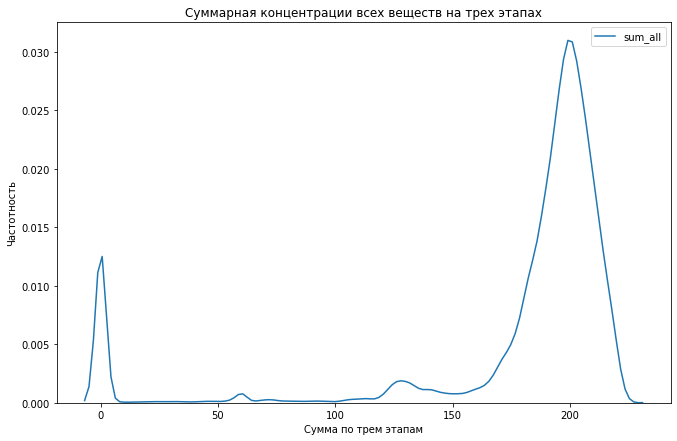

In [20]:
sns.kdeplot(data_full['sum_all'])\
        .set(xlabel='Сумма по трем этапам', ylabel='Частотность', 
             title='Суммарная концентрации всех веществ на трех этапах')
plt.show()

Пик около нуля сохранился, а значит, у нас есть строки, в которых все три значения равны нулю. Также верным будет допустить погрешность в 0.25 для учета очень маленьких значений в случаях, когда в каком-то одном столбце все-таки есть минимальное значение. 

Оставим в учебной и тестовой выборках только строки с индексами неотрицательных значений столбца sum_all в data_full. 

In [21]:
data_train = data_train[data_full['sum_all'] > 0.25]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13754 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 54 columns):
primary_cleaner.input.sulfate                 13754 non-null float64
primary_cleaner.input.depressant              13754 non-null float64
primary_cleaner.input.feed_size               13754 non-null float64
primary_cleaner.input.xanthate                13754 non-null float64
primary_cleaner.state.floatbank8_a_air        13754 non-null float64
primary_cleaner.state.floatbank8_a_level      13754 non-null float64
primary_cleaner.state.floatbank8_b_air        13754 non-null float64
primary_cleaner.state.floatbank8_b_level      13754 non-null float64
primary_cleaner.state.floatbank8_c_air        13754 non-null float64
primary_cleaner.state.floatbank8_c_level      13754 non-null float64
primary_cleaner.state.floatbank8_d_air        13754 non-null float64
primary_cleaner.state.floatbank8_d_level      13754 non-null float64
rougher.input.feed_ag       

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [22]:
data_test = data_test[data_full['sum_all'] > 0.25]
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5268 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
primary_cleaner.input.sulfate                 5268 non-null float64
primary_cleaner.input.depressant              5268 non-null float64
primary_cleaner.input.feed_size               5268 non-null float64
primary_cleaner.input.xanthate                5268 non-null float64
primary_cleaner.state.floatbank8_a_air        5268 non-null float64
primary_cleaner.state.floatbank8_a_level      5268 non-null float64
primary_cleaner.state.floatbank8_b_air        5268 non-null float64
primary_cleaner.state.floatbank8_b_level      5268 non-null float64
primary_cleaner.state.floatbank8_c_air        5268 non-null float64
primary_cleaner.state.floatbank8_c_level      5268 non-null float64
primary_cleaner.state.floatbank8_d_air        5268 non-null float64
primary_cleaner.state.floatbank8_d_level      5268 non-null float64
rougher.input.feed_ag                    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Удаление строк с нулевыми значениями прошло успешно. 

# Вывод 

В этом блоке мы посмотрели, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Мы увидели, что концентрация золота и свинца с прохождением каждого этапа растет, а вот концентрация серебра растет после флотации и падает после прохождения следующих этапов.

Мы сравнили распределения размеров гранул сырья на обучающей и тестовой выборках и увидели, что распределеения размеров гранул сырья на обучающей и тестовой выборках очень похожи, а значит, значения этого признака не будут негативно влиять на оценку модели.

Мы исследовали суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах и заметили пики около нуля в сырье и черновом концентрате. Нулевые значения, скорее всего, являются ошибкой оператора. Эти данные будут негативно влиять на обучение модели, потому что являются не реальными данными. Мы удалили строки с нулевыми значениями. 

# 3. Модель

Построим модель. <br>
Напишем функцию для вычисления итоговой метрики - sMAPE.<br>
Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке.

### Функция sMAPE

In [23]:
def smape(y_true, y_pred):
    return  np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

def full_smape(smape_rougher, smape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final

custom_scorer = make_scorer(smape, greater_is_better=False)

### Деление выборок на target и features

Разделим тренировочную и тестовую выборки на признаки и целевые признаки. Напомним, что наши целевые признаки - rougher.output.recovery и final.output.recovery. 

In [24]:
features_train = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_rougher_train = data_train['rougher.output.recovery']
target_final_train = data_train['final.output.recovery']

features_test = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_rougher_test = data_test['rougher.output.recovery']
target_final_test = data_test['final.output.recovery']

### Работа с моделью для целевого признака  rougher.output.recovery

С помощью кросс-валидации проверим качество нескольких моделей: дерево решений, случайный лес, линейная регрессия.

In [25]:
# Дерево решений
model_tree = DecisionTreeRegressor(random_state=12)
cross_val_score(model_tree, features_train, target_rougher_train, cv=5, scoring=custom_scorer).mean()

-20.789457583550085

In [26]:
# Случайный лес
model_forest = RandomForestRegressor(random_state=12)
cross_val_score(model_forest, features_train, target_rougher_train, cv=5, scoring=custom_scorer).mean()

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

-14.325720630770153

In [27]:
# Линейная регрессия
model_lr = LinearRegression()
cross_val_score(model_lr, features_train, target_rougher_train, cv=5, scoring=custom_scorer).mean()

-12.337083807369847

Для метрики sMAPE наилучший результат - наиболее близкий к нулю. Мы видим, что линейная регрессия показала себя лучше всего. Параметры линейной регрессии мы не подбираем, поэтому просто оставим эту модель. Проверим работу модели на тестовой выборке и зафиксируем значение. 

In [28]:
model_lr.fit(features_train, target_rougher_train)
predicted = model_lr.predict(features_test)
smape_rougher = smape(target_rougher_test, predicted)
smape_rougher

9.91097695193762

Сравним значение sMAPE нашей модели с константным значением. Посмотрим общую информацию о распределении признака целевого признака.

In [29]:
target_rougher_train.describe()

count    13754.000000
mean        82.920043
std         14.436681
min          0.000000
25%         80.260927
50%         85.486305
75%         90.264484
max        100.000000
Name: rougher.output.recovery, dtype: float64

Среднее и медианное значение, на первый взгляд, не сильно отличаются, но среднее значение гораздо ближе к 25% квантилю, поэтому мы возьмем медианное. Создадим список с константным медианным значением. 

In [30]:
target_rougher_median = np.array([target_rougher_train.median()] * len(target_rougher_test))
target_rougher_median

array([85.48630481, 85.48630481, 85.48630481, ..., 85.48630481,
       85.48630481, 85.48630481])

Проверим значение sMAPE для константной модели. 

In [31]:
smape_rougher_median = smape(target_rougher_test, target_rougher_median)
smape_rougher_median

8.454126775222075

### Работа с моделью для целевого признака final.output.recovery

С помощью кросс-валидации проверим качество нескольких моделей: дерево решений, случайный лес, линейная регрессия. 


In [32]:
# Дерево решений
model_tree = DecisionTreeRegressor(random_state=12)
cross_val_score(model_tree, features_train, target_final_train, cv=5, scoring=custom_scorer).mean()

-19.54757337525876

In [33]:
# Случайный лес
model_forest = RandomForestRegressor(random_state=12)
cross_val_score(model_forest, features_train, target_final_train, cv=5, scoring=custom_scorer).mean()

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

-12.558879925204884

In [34]:
# Линейная регрессия
model_lr = LinearRegression()
cross_val_score(model_lr, features_train, target_final_train, cv=5, scoring=custom_scorer).mean()

-11.282499389851242

Как и в случае с предыдущим целевым признаком, мы видим, что линейная регрессия показала себя лучше всего. Параметры линейной регрессии мы не подбираем, поэтому просто оставим эту модель. Проверим работу модели на тестовой выборке и зафиксируем значение.

In [35]:
model_lr.fit(features_train, target_final_train)
predicted = model_lr.predict(features_test)
smape_final = smape(target_final_test, predicted)
smape_final

9.288782528608383

Сравним значение sMAPE нашей модели с константным значением. Посмотрим общую информацию о распределении признака целевого признака.

In [36]:
target_final_train.describe()

count    13754.000000
mean        66.863242
std          9.746011
min          0.000000
25%         62.906219
50%         67.585567
75%         72.470767
max        100.000000
Name: final.output.recovery, dtype: float64

Как и в случае с первым признаком, надежнее будет использовать медианное значение. 

In [37]:
target_final_median = np.array([target_final_train.median()] * len(target_final_test))
target_final_median

array([67.58556712, 67.58556712, 67.58556712, ..., 67.58556712,
       67.58556712, 67.58556712])

Проверим значение sMAPE для константной модели.

In [38]:
smape_final_median = smape(target_rougher_test, target_final_median)
smape_final_median

28.161708976465206

Значение константной модели значительно выше значения нашей модели (на 19 пунктов). Значит, работа нашей модели имеет смысл. Посчитаем финальный показатель sMAPE моделей для предсказания двух признаков. 

In [39]:
full_smape(smape_rougher, smape_final)

9.444331134440691

# Вывод

С помощью кросс-валидации мы проанализировали значения кастомной метрики sMAPE для различных моделей и выбрали лучшую модель. Ей оказалась линейная регрессия. Итоговое значение sMAPE по признакам rougher и final получилось 9.4. 

# Общий вывод

Мы загрузили данные, проверили верность расчетов целевых признаков, удалили лишние столбцы в выборках, добавили нужные. Удалили строки с пропусками в целевых признаках и заполнили пропуски в остальных признаках.

Мы посмотрели, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Мы увидели, что концентрация золота и свинца с прохождением каждого этапа растет, а вот концентрация серебра растет после флотации и падает после прохождения следующих этапов.

Мы сравнили распределения размеров гранул сырья на обучающей и тестовой выборках и увидели, что распределеения размеров гранул сырья на обучающей и тестовой выборках очень похожи, а значит, значения этого признака не будут негативно влиять на оценку модели.

Мы исследовали суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах и заметили пики около нуля в сырье и черновом концентрате. Нулевые значения, скорее всего, являются ошибкой оператора. Эти данные будут негативно влиять на обучение модели, потому что являются не реальными данными. Мы удалили строки с нулевыми значениями.

С помощью кросс-валидации мы проанализировали значения кастомной метрики sMAPE для различных моделей и выбрали лучшую модель. Ей оказалась линейная регрессия. Итоговое значение sMAPE по признакам rougher и final получилось 9.4.